<a href="https://colab.research.google.com/github/ArtStyle19/prediccion-de-enfermedades-cardiovasculares-ML/blob/main/collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Paso III**


In [52]:
import kagglehub
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 1. Descargar la última versión del dataset de Heart Disease en Kaggle
path = kagglehub.dataset_download("johnsmith88/heart-disease-dataset")
print("Archivos descargados en:", path)

# 2. Cargar el archivo CSV
file_path = os.path.join(path, "heart.csv")
df = pd.read_csv(file_path)

print("Dataset original:", df.shape)
print(df.head())

# 3. Definir variables de entrada y salida
features = [
    "age", "sex", "cp", "trestbps", "chol", "fbs",
    "restecg", "thalach", "exang", "oldpeak",
    "slope", "ca", "thal"
]
target = "target"  # 0 = no enfermedad, 1 = enfermedad

X = df[features]
y = df[target]

# 4. Variables numéricas y categóricas
numeric_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

# 5. Pipelines de preprocesamiento
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # imputar faltantes
    ("scaler", StandardScaler())                     # normalizar
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # imputar categóricas
    ("encoder", OneHotEncoder(handle_unknown="ignore"))    # one-hot encoding
])

# 6. Combinar transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# 7. Aplicar preprocesamiento
X_prepared = preprocessor.fit_transform(X)

print("\nDataset transformado (listo para ML):", X_prepared.shape)


Using Colab cache for faster access to the 'heart-disease-dataset' dataset.
Archivos descargados en: /kaggle/input/heart-disease-dataset
Dataset original: (1025, 14)
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  

Dataset transformado (listo para ML): (1025, 30)


In [53]:
import pandas as pd
import numpy as np

# X_prepared es un array (después del preprocesamiento)
# Lo convertimos a DataFrame para que sea más fácil de usar en el Paso 4
X_prepared_df = pd.DataFrame(X_prepared.toarray() if hasattr(X_prepared, "toarray") else X_prepared)

# Guardar en CSV
X_prepared_df.to_csv("X_prepared.csv", index=False)

# Guardar también la variable objetivo (target)
y.to_csv("y.csv", index=False)


In [54]:
# from google.colab import drive
# drive.mount('/content/drive')

**Paso IV**



--- Resultados de todas las iteraciones ---
Logistic Regression: {'Accuracy': 0.8731707317073171, 'Precision': 0.8558558558558559, 'Recall': 0.9047619047619048, 'F1': 0.8796296296296297, 'AUC': np.float64(0.9448571428571428)}
Decision Tree: {'Accuracy': 0.9853658536585366, 'Precision': 1.0, 'Recall': 0.9714285714285714, 'F1': 0.9855072463768116, 'AUC': np.float64(0.9857142857142858)}
Random Forest: {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1': 1.0, 'AUC': np.float64(0.9999999999999999)}
SVM: {'Accuracy': 0.9463414634146341, 'Precision': 0.9351851851851852, 'Recall': 0.9619047619047619, 'F1': 0.9483568075117371, 'AUC': np.float64(0.9773333333333333)}

El mejor modelo según Recall es: Random Forest


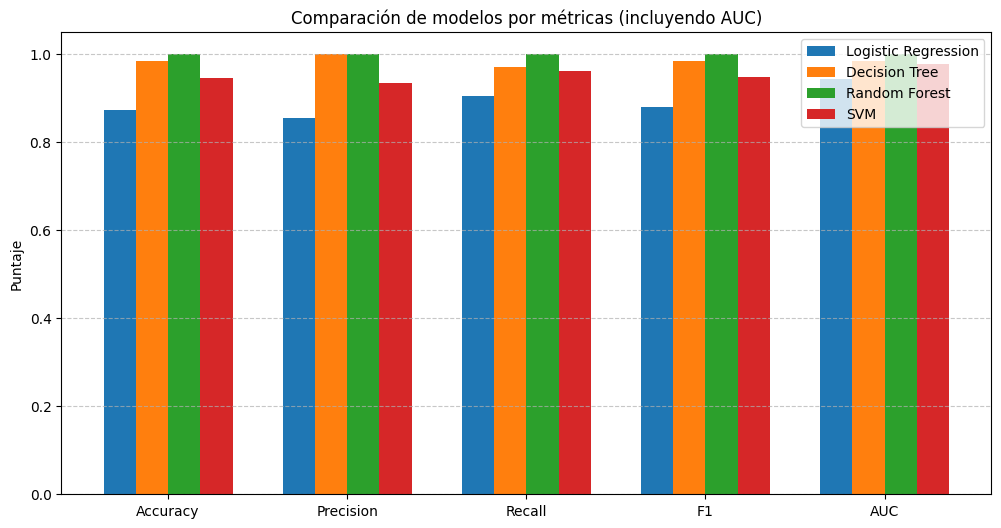

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1. Separar train y test
X_train, X_test, y_train, y_test = train_test_split(
    X_prepared, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Definir modelos a evaluar (iteraciones)
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced"),
    "SVM": SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=42)
}

resultados = {}

# 3. Entrenar y evaluar cada modelo
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Probabilidades necesarias para AUC
    if hasattr(modelo, "predict_proba"):
        y_scores = modelo.predict_proba(X_test)[:, 1]
    else:  # Para SVM si no tiene predict_proba
        y_scores = modelo.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_scores)

    resultados[nombre] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc
    }

# 4. Mostrar resultados en consola
print("\n--- Resultados de todas las iteraciones ---")
for nombre, metricas in resultados.items():
    print(f"{nombre}: {metricas}")

# 5. Selección del mejor modelo (según Recall)
mejor_modelo = max(resultados, key=lambda m: resultados[m]["Recall"])
print(f"\nEl mejor modelo según Recall es: {mejor_modelo}")

# 6. Graficar resultados
metricas = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
n_modelos = len(resultados)
x = np.arange(len(metricas))  # posiciones en el eje X
width = 0.18  # ancho de cada barra

plt.figure(figsize=(12, 6))

# Dibujar barras para cada modelo
for i, (nombre, vals) in enumerate(resultados.items()):
    valores = [vals[m] for m in metricas]
    plt.bar(x + i*width, valores, width=width, label=nombre)

# Personalización del gráfico
plt.xticks(x + width * (n_modelos-1) / 2, metricas)
plt.ylabel("Puntaje")
plt.ylim(0, 1.05)
plt.title("Comparación de modelos por métricas (incluyendo AUC)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


**PASO V**

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cargar dataset
# df = pd.read_csv("heart.csv")

# ---------------------------
# 1. Separar variables (X) y target (y)
# ---------------------------
X = df.drop("target", axis=1)
y = df["target"]

# ---------------------------
# 2. One-Hot Encoding para variables categóricas
# ---------------------------
categorical_cols = ["cp", "thal", "slope", "restecg", "sex", "fbs", "exang"]
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# ---------------------------
# 3. Escalado de variables numéricas
# ---------------------------
scaler = StandardScaler()
num_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
X[num_cols] = scaler.fit_transform(X[num_cols])

# ---------------------------
# 4. División en train/test
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Tamaño de entrenamiento:", X_train.shape)
print("Tamaño de prueba:", X_test.shape)


Tamaño de entrenamiento: (820, 19)
Tamaño de prueba: (205, 19)


In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# ---------------------------
# 1. Regresión Logística
# ---------------------------
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("📌 Regresión Logística")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

# ---------------------------
# 2. Random Forest
# ---------------------------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("📌 Random Forest")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# ---------------------------
# 3. SVM
# ---------------------------
svm = SVC(kernel="rbf", probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("📌 SVM")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


📌 Regresión Logística
[[78 22]
 [ 9 96]]
              precision    recall  f1-score   support

           0       0.90      0.78      0.83       100
           1       0.81      0.91      0.86       105

    accuracy                           0.85       205
   macro avg       0.86      0.85      0.85       205
weighted avg       0.85      0.85      0.85       205

📌 Random Forest
[[100   0]
 [  0 105]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205

📌 SVM
[[ 88  12]
 [  5 100]]
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       100
           1       0.89      0.95      0.92       105

    accuracy                           0.92       205
   macro avg       

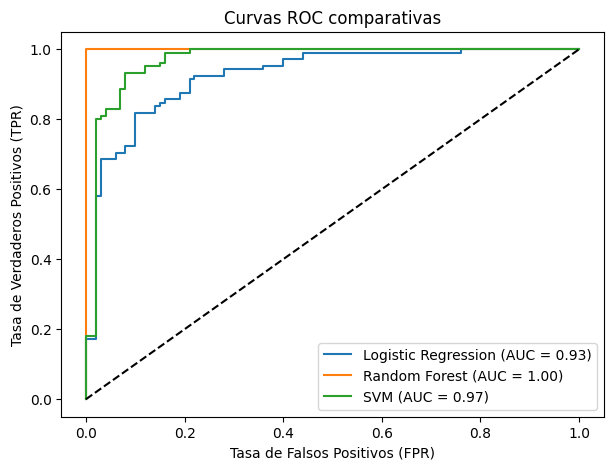

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Obtener probabilidades para curva ROC
y_proba_log = log_reg.predict_proba(X_test)[:,1]
y_proba_rf = rf.predict_proba(X_test)[:,1]
y_proba_svm = svm.predict_proba(X_test)[:,1]

# Calcular FPR y TPR
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)

roc_auc_log = auc(fpr_log, tpr_log)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Graficar curvas ROC
plt.figure(figsize=(7,5))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_log:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.2f})")
plt.plot([0,1], [0,1], "k--")  # Línea aleatoria
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curvas ROC comparativas")
plt.legend()
plt.show()


In [59]:
import joblib

# Guardar el modelo final (Random Forest en este caso)
joblib.dump(rf, "modelo_cardiaco.pkl")

# Guardar el scaler también (importante para preprocesar datos nuevos)
joblib.dump(scaler, "scaler.pkl")

print("Modelo y scaler guardados correctamente.")


Modelo y scaler guardados correctamente.


In [60]:
# Cargar modelo y scaler
modelo = joblib.load("modelo_cardiaco.pkl")
scaler = joblib.load("scaler.pkl")

# Ejemplo: nuevo paciente
nuevo_paciente = pd.DataFrame([{
    "age": 52,
    "trestbps": 130,
    "chol": 250,
    "thalach": 160,
    "oldpeak": 1.0,
    "cp": 2,
    "thal": 2,
    "slope": 1,
    "restecg": 0,
    "sex": 1,
    "fbs": 0,
    "exang": 0
}])

# Aplicar mismo preprocesamiento
nuevo_paciente = pd.get_dummies(nuevo_paciente, columns=categorical_cols, drop_first=True)
for col in X.columns:
    if col not in nuevo_paciente.columns:
        nuevo_paciente[col] = 0
nuevo_paciente = nuevo_paciente[X.columns]

# Escalar variables numéricas
nuevo_paciente[num_cols] = scaler.transform(nuevo_paciente[num_cols])

# Predicción
prediccion = modelo.predict(nuevo_paciente)
print("✅ Riesgo de enfermedad cardíaca" if prediccion[0]==1 else "❌ Sin riesgo")


✅ Riesgo de enfermedad cardíaca


In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
